### 情報元
sklearn.feature_selectionで特徴量選定【scikit-learn】  
https://cpp-learning.com/sklearn-feature-selection/  

### ライブラリのインストール

In [ ]:
!pip install --upgrade scikit-learn
!pip install category_encoders

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.24.1)


### ライブラリのインポート

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import time
 
from sklearn.ensemble import RandomForestClassifier

import category_encoders as ce
 
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel

### データの読込

In [ ]:
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/raw/titanic.csv"
df = pd.read_csv(url)

In [ ]:
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.isnull().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

In [ ]:
df.columns

Index(['survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked'],
      dtype='object')

In [ ]:
X = df[[ 'pclass', 'name', 'sex', 'sibsp', 'parch', 'ticket','fare', 'embarked']]
y = df['survived']

### 欠損値処理

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


pclass      0
name        0
sex         0
sibsp       0
parch       0
ticket      0
fare        0
embarked    0
dtype: int64

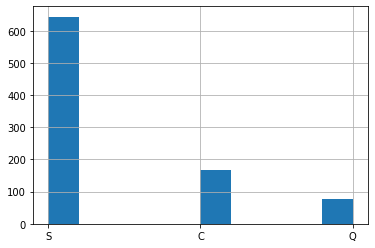

In [ ]:
X['embarked'].hist()
X['embarked'] = X['embarked'].fillna("S")
X.isnull().sum()

### OneHotEncoding

In [ ]:
print(X.columns)
X.head()

Index(['pclass', 'name', 'sex', 'sibsp', 'parch', 'ticket', 'fare',
       'embarked'],
      dtype='object')


,pclass,name,sex,sibsp,parch,ticket,fare,embarked
0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C
2,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,S
4,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,S


In [ ]:
ce_ohe = ce.OneHotEncoder(cols=['name', 'sex', 'ticket', 'embarked'],handle_unknown='impute')

In [ ]:
X_onehot = ce_ohe.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
X_onehot.head()

,pclass,name_1,name_2,name_3,name_4,name_5,name_6,name_7,name_8,name_9,name_10,name_11,name_12,name_13,name_14,name_15,name_16,name_17,name_18,name_19,name_20,name_21,name_22,name_23,name_24,name_25,name_26,name_27,name_28,name_29,name_30,name_31,name_32,name_33,name_34,name_35,name_36,name_37,name_38,name_39,...,ticket_646,ticket_647,ticket_648,ticket_649,ticket_650,ticket_651,ticket_652,ticket_653,ticket_654,ticket_655,ticket_656,ticket_657,ticket_658,ticket_659,ticket_660,ticket_661,ticket_662,ticket_663,ticket_664,ticket_665,ticket_666,ticket_667,ticket_668,ticket_669,ticket_670,ticket_671,ticket_672,ticket_673,ticket_674,ticket_675,ticket_676,ticket_677,ticket_678,ticket_679,ticket_680,ticket_681,fare,embarked_1,embarked_2,embarked_3
0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.2500,1,0,0
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,71.2833,0,1,0
2,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.9250,1,0,0
3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53.1000,1,0,0
4,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0500,1,0,0


### 学習

In [ ]:
model = RandomForestClassifier(n_estimators=10)

### Forward SFS

In [ ]:
start = time.time()

n_features = 3
sfs = SequentialFeatureSelector(model, n_features_to_select=n_features, direction='forward')
sfs.fit(X_onehot, y)
 
print("Top {} features selected by forward sequential selection (direction='forward')".format(n_features))
print(X_onehot.columns[sfs.get_support()])

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

Top 3 features selected by forward sequential selection (direction='forward')
Index(['name_144', 'sex_1', 'fare'], dtype='object')
elapsed_time:417.49776005744934[sec]


### Backward SFS(重いのでカット)

start = time.time()

n_features = 3
sfs = SequentialFeatureSelector(model, n_features_to_select=n_features, direction='backward')
sfs.fit(X_onehot, y)
 
print("Top {} features selected by forward sequential selection (direction='backward')".format(n_features))
print(X_onehot.columns[sfs.get_support()])

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

### SelectFromModel

In [ ]:
start = time.time()

threshold = 0.15
sfm = SelectFromModel(model, threshold=threshold)
sfm.fit(X_onehot, y)

print("Feature selection using SelectFromModel (threshold={})".format(threshold))
print(X_onehot.columns[sfm.get_support()])

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

### 可視化

In [ ]:
start = time.time()

# 閾値
threshold = 0.15
 
# 学習
model = RandomForestClassifier(n_estimators=10)
model.fit(X_onehot, y)
 
# 特徴量重要度
importances = model.feature_importances_
print(importances)
 
# 可視化
plt.figure(figsize=(14,4))
plt.bar(height=importances, x=X.columns)
plt.hlines(y=threshold, xmin=-1, xmax=len(X.columns), colors="red", linestyle="--", lw=2)
plt.ylabel("Feature importances", color='tab:red', fontsize=16, labelpad=20, weight='bold')
plt.xticks(rotation=90);

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")